In [1]:
from datetime import datetime, timedelta
import os
import time
import requests
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import doctor
import math
from IPython.display import clear_output
import main
import seaborn as sea
import matplotlib.patches as patches
import matplotlib as mpl
import ryan_tools as rt
import keras as kr
import glob

C:\Users\rfrancis\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Open

In [230]:
def plot_candles(candles, signal, fig, ax):
    def add_rectangle(i, open_, close,low, high, ax, sig):
        x = i - .5
        y = min(open_, close)
        height = abs(open_ - close)
        if sig == 'buy':
            color = 'green'
            hatch = 'x'
        if sig == 'sell':
            color = 'red'
            hatch = ''
            
        if sig == 'hold':
            color = 'orange'
            hatch = ''
        ax.add_patch(patches.Rectangle((x, y), .9, height,
                                       fill = open_ <= close, facecolor = color,
                                       edgecolor = color, hatch = hatch ))
        top = max(open_,close)
        bottom = min(open_,close)

        if low < bottom:
            ax.add_line(mpl.lines.Line2D([i,i], [low, bottom], color = color) )

            
        if high > top:
            ax.add_line(mpl.lines.Line2D([i,i], [high, top], color = color) )

        
    for i, index in enumerate(candles.index):
        sig = signal.loc[index]
        row = candles.loc[index]
        add_rectangle(i, row['open'], row['close'],row['low'], row['high'],  ax, sig)
    ax.set_xlim(0, len(candles))
    ax.set_ylim(candles['close'].min() *.998, candles['close'].max() * 1.002)
    return ax

In [3]:
def chartio(gran = 60, cans = False, count = False):
    if type(cans) == type(False):
        cans = aba.get_candles(granularity= gran)
    if count == False:
        count = len(cans)
    mask = cans['open']< cans['close']
    signal = pd.Series(index = cans.index )
    signal.loc[mask] = 'buy'
    signal.loc[~mask] = 'sell'

    
    
    fig, (ax, sig_ax) = plt.subplots(nrows = 2, sharex= False)
    fig.set_size_inches(7, 9)
    plot_candles(cans[-count:], signal[-count:], fig, ax)
    ax.set_xticklabels(cans.index)
    ax2 = ax.twinx()
    cans.iloc[-count:]['volume'].plot(kind = 'bar', ax = ax2, alpha = 0.3)
    

    rsi = aba.get_rsi(cans['close'])
    macd = aba.get_macd(cans)
    rsi.plot(ax = sig_ax, alpha = 0.1)
    ax4 = sig_ax.twinx()
    macd[['macd', 'macd_signal']].plot(ax = ax4)
    plt.show()
    

In [4]:
aba = main.Abathor('LTC-USD')

In [5]:
def save_observations(observations):
    for i, df in enumerate( observations):
        dire = os.getcwd() + '\\data\\{}.pkl'.format(i)
        df.to_pickle(dire)

In [6]:
def load_observations():
    observations = []
    os.chdir('data')
    for file in glob.glob('*.pkl'):
        observations.append(pd.read_pickle(file))
    os.chdir('..')
    return observations

In [7]:
observations = load_observations()
save_observations(observations)

In [8]:
def get_random_candles(seconds = 60.00):
    days = np.random.randint(1, 500)
    hours = np.random.randint(0, 12)
    minutes = np.random.randint(0,60)
    start = datetime.today() - timedelta(days = days, hours = hours, minutes = minutes )
    end = start + timedelta(seconds = seconds * 200)
    cans =  aba.get_candles(start, end, granularity = seconds)
    observations.append(cans)
    save_observations(observations)
    return cans

In [9]:
#to_download = 100
#bar = rt.progress_bar(to_download)
#for num in range(0, to_download):
#    get_random_candles()
#    bar.progress()

In [10]:
def get_time_range(start, end, gran = 60):
    next_val = start + timedelta(seconds = 200 * gran)
    result = pd.DataFrame()
    bar = rt.progress_bar((end - start).total_seconds()/(gran* 200))
    while next_val < end:
        bar.progress()
        temp = aba.get_candles(start, next_val, gran)
        result = result.append(temp)
        start = next_val
        next_val = next_val + timedelta(seconds = 200 * gran)
    return result

In [11]:
start = datetime.today() - timedelta(days= 20)
x = get_time_range(start, datetime.today())

0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o> | 100.00 % 
Done: 143 Remaining: 1.0000000833333331, Remaining Time: 2s


In [418]:
class Testy():
    cash = None
    coin = None
    position = None
    trades = None
    def __init__(self, cash = 100, coin = 0, position = 'out'):
        assert(position in ('in', 'out'))
        self.cash = cash
        self.coin = coin
        self.position = position
        self.trades = 0
        
    def sell(self, p):
        if self.position == 'out':
            return 
        self.cash = self.coin * p
        self.coin = 0
        self.position = 'out'
        self.trades = self.trades + 1
        return 
    
    def buy(self, p):
        if self.position == 'in':
            return
        self.coin = self.cash/p
        self.cash = 0
        self.position = 'in'
        self.trades = self.trades + 1
        return
        

    def test_signal(self, prices, signal):
        for i in range(len(signal)):
            p = prices.iloc[i]
            s = signal.iloc[i]
            if s == 'sell':
                self.sell(p)
            if s == 'buy':
                self.buy(p)
            if s == 'hold':
                s = 'hold'
                
        self.sell(p)
        return self.cash, self.coin, self.trades


In [419]:
def volume_info(x_in):
    x = x_in.copy()
    x['vol_up'] = x.loc[x['close'] >= x['open'],'volume']
    x['vol_down'] = x.loc[x['close'] < x['open'],'volume']
    x['vol_up'] = x['vol_up'].fillna(0)
    x['vol_down'] = x['vol_down'].fillna(0)
    return x

def bolinger_signal(x_in, length=30, numsd=2):
    def bbands(price, length, numsd):
        """ returns average, upper band, and lower band"""
        ave = price.rolling(window=length, center=False).mean()
        sd = price.rolling(window=length,center=False).std()
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return np.round(ave,3), np.round(upband,3), np.round(dnband,3)
    x = x_in.copy()
    x['avg'], x['upper'], x['lower'] = bbands(x['close'], length, numsd)
    return x

In [420]:
def plot_signal(ax, prices, signal):
    last_sig = signal.iloc[0]
    batch_x = []
    batch_y = []
    for i, s in enumerate(signal):
        if last_sig == 'buy':
            color = 'green'
        if last_sig == 'sell':
            color = 'red'
        if last_sig == 'hold':
            color = 'blue'
            
        p = prices.iloc[i]
        if s == last_sig:
            batch_x.append(prices.index[i])
            batch_y.append(p)
        if s != last_sig:
            batch_x.append(prices.index[i])
            batch_y.append(p)
            ax.plot(batch_x, batch_y, color = color)
            batch_x = [prices.index[i]]
            batch_y = [p]
        last_sig = s
    ax.plot(batch_x, batch_y, color = color)
            

In [ ]:
d

In [ ]:
def test_time_period(x, time, sd):
    data = volume_info(bolinger_signal(x,time, numsd=sd))
    data['width'] = data['upper'] - data['lower']
    data = data.dropna()
    data['signal'] = 'hold'
    data.loc[data['close'] < data['avg'], 'signal'] = 'sell'
    data.loc[data['close'] > data['upper'], 'signal'] = 'buy'
    
    test = Testy()
    test.test_signal(data['close'], data['signal'])
    return test

result = pd.DataFrame(index = list(range(5,1000)))
for index in result.index:
    test = test_time_period(x, index, 2)

    print('Trades : ', test.trades)
    print(index,' - ' ,test.cash)
    result.loc[index, 'cash'] = test.cash
    result.loc[index, 'trades'] = test.trades
    t = result[~result['cash'].isnull()]
    fig, ax = plt.subplots()
    ax.plot(t['cash'])
    ax2 = ax.twinx()
    ax2.plot(t['trades'], color = 'green')
    plt.show()
    rt.clear_output(True)
    
    

100


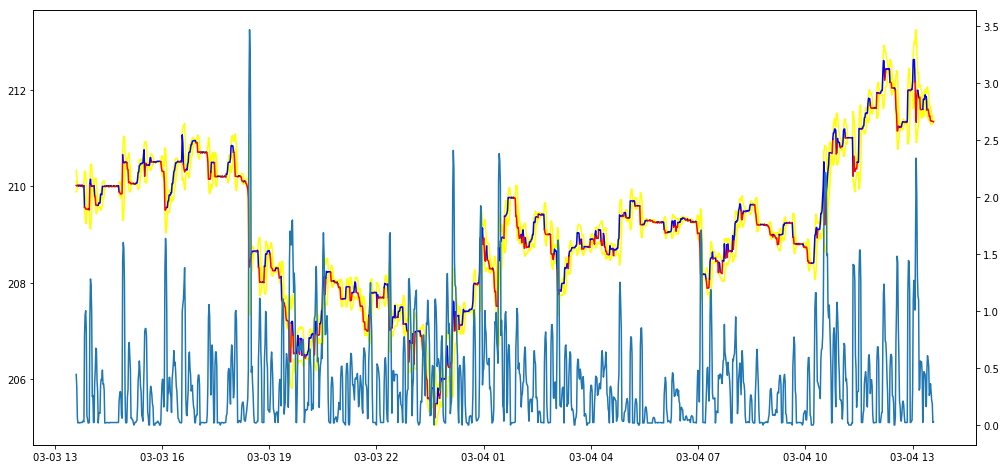

In [349]:
data = volume_info(bolinger_signal(x,5, numsd=2))
data['width'] = data['upper'] - data['lower']
data = data.dropna()
data['signal'] = 'hold'
data.loc[data['close'] < data['avg'], 'signal'] = 'sell'
data.loc[data['close'] > data['upper'], 'signal'] = 'buy'
#data.loc[data['close'] < data['lower'], 'signal'] = 'sell'


final = data.copy()
final['price'] = x['close']
final = final.sort_index( ascending = True)
day = 5
final = final.loc[datetime.today()- timedelta(days = (1 + day)):datetime.today()- timedelta(days = day)]
fig, ax = plt.subplots()
fig.set_size_inches(13 * 1.3, 8 )

test = backtest(final['close'], final['signal'])
print(test[0])

ax.plot(final.index, final['upper'], color=  'yellow')
ax.plot(final.index, final['lower'], color=  'yellow')
ax.plot(final.index, final['avg'], color=  'yellow')
plot_signal(ax, final['close'], final['signal'])

#ax2 = ax.twinx()
#ax2.plot(final.index, final['width'], color = 'green', alpha = .4)

#ax2.plot(final.index, final['signal'], color = 'green', alpha = .4)
#ax2.plot(final.index, final['fast'], color = 'green', alpha = .4)
#ax2.plot(final.index, final['slow'], color = 'red', alpha = .4)
#lims = ax2.get_xlim()
#ax2.hlines(top, lims[0],lims[1])
#ax2.hlines(bottom,lims[0],lims[1])


ax_v = ax.twinx()
ax_v.plot(final.index, final['width'])

#ax_v.bar(x = final.index,height=  final['vol_up'], width = 0.0025, alpha = .1, color = 'green')
#ax_v.bar(x = final.index,height=  final['vol_down'], width = 0.0025, alpha = .1, color = 'red')
    

plt.show()
